# Control Tutorial_8
_Reference : The Control Handbook, Control System Fundamentals, Edited by William S.Levine from p9-100 to p9-123_,  

# Internal Model Control (IMC)
---
The IMC structure is shown like the figure.

<img src="figures/IMC.png" hight="150">

Where $d$ is an unknown disturbance affecting the system. The manipulated input $u$ is introdused to both the plant and its model.
The controller $C(s)$ is given by:

$$
C(s) = F(s)G_M^{-1}(s)
$$

Where $G_M^{-1}(s)$ is the inverse of the transfer function of the model, and $F(s)$ is a filter which is used to keep the dimension of the denominator is second higher than the dimension of the numerator.  
In general, this filter is given by:

$$
F(s) = \frac{1}{(1+\alpha s)^n}
$$

The transfer function from the reference $r$ and the disturbances $d$ to the output $y$ is described as:

$$
y(s) = \frac{G_P(s)C(s)}{1+\{G_P(s)-G_M(s)\}C(s)}r(s) + \frac{1-G_M(s)C(s)}{1+\{G_P(s)-G_M(s)\}C(s)}d(s)
$$

# Simulation (Using transfer function)
The "Sympy" module is useful for the calculation of the transfer function.

In [1]:
from scipy import signal
import numpy as np
import sympy as sy
s,t = sy.symbols('s t') # Declaration of the variables

In [2]:
def lti_to_sympy(lsys, symplify=True):
    """ Convert Scipy's LTI instance to Sympy expression """
    s = sy.Symbol('s')
    G = sy.Poly(lsys.num, s) / sy.Poly(lsys.den, s)
    return sy.simplify(G) if symplify else G

def sympy_to_lti(xpr, s=sy.Symbol('s')):
    """ Convert Sympy transfer function polynomial to Scipy LTI """
    num, den = sy.simplify(xpr).as_numer_denom()  # expressions
    p_num_den = sy.poly(num, s), sy.poly(den, s)  # polynomials
    c_num_den = [sy.expand(p).all_coeffs() for p in p_num_den]  # coefficients
    l_num, l_den = [sy.lambdify((), c)() for c in c_num_den]  # convert to floats
    return signal.lti(l_num, l_den)

## Example (RC circuit)
<img src="figures/RC.png" hight="150">
We try to control the simple first order system, the RC circuit using IMC.
The transfer function of the plant is written as

$$
G_P(s) = \frac{Y(s)}{X(s)} = \frac{1}{CRs+1} 
$$

Also, we set a filter for the controller like:

$$
F(s) = \frac{1}{(1+\alpha s)^1} = \frac{1}{1+\alpha s}
$$

The $n=1$ is enough to keep the controller stable, and we set $\alpha=0.1$

In [3]:
def Plant(C,R):
    num = [1] 
    den = [C*R, 1] 
    return signal.lti(num, den)

In [4]:
def Filter(a=0.1):
    num = [1] 
    den = [a,1] 
    return signal.lti(num, den)

Now we estimate the model. To compare the result, we introduse two transfer functions of the model.  

- One is 

$$G_M(s) = G_P(s) = \frac{1}{CRs+1}$$

which means there is no modelling error, and the model is completely same as the plant.

- The other is  

$$G_M(s) = \frac{1}{\hat{C}\hat{R}s+1}$$ 

which means the model has the modelling error. 

In this example, we set $C=1$, $R=1$, $\hat{C}=1.2$, $\hat{R}=1.5$  

Now the controller can be obtained using $C(s) = F(s)G_M^{-1}(s)$.

In [5]:
G_P = Plant(1,1)
F = Filter()
G_M_error = Plant(1.2,1.5)

We convert transfer functions in to sympy expression to make it possible to multiply them.

In [6]:
G_Ps, Fs = lti_to_sympy(G_P), lti_to_sympy(F)

G_Ms = G_Ps
G_Ms_error = lti_to_sympy(G_M_error)

Cs = Fs*np.reciprocal(G_Ms)
Cs_error = Fs*np.reciprocal(G_Ms_error)

This system has two inputs and one output, so the transfer function is written as 

$$
y(s) = \frac{G_P(s)C(s)}{1+\{G_P(s)-G_M(s)\}C(s)}r(s) + \frac{1-G_M(s)C(s)}{1+\{G_P(s)-G_M(s)\}C(s)}d(s) = H1(s)\cdot r(s) + H2(s)\cdot d(s)
$$

In [7]:
H1s = sy.nsimplify(Cs*G_Ps / (1+(G_Ps-G_Ms)*Cs)).expand()
H2s = sy.nsimplify((1-G_Ms*Cs)/(1+(G_Ps-G_Ms)*Cs)).expand()

H1s_error = sy.nsimplify(Cs_error*G_Ps / (1+(G_Ps-G_Ms_error)*Cs_error)).expand()
H2s_error = sy.nsimplify((1-G_Ms_error*Cs_error)/(1+(G_Ps-G_Ms_error)*Cs_error)).expand()

We convert transfer functions $H1(s)$, $H2(s)$ into scipy expression again.

In [8]:
H1, H2 = sympy_to_lti(H1s), sympy_to_lti(H2s)
H1_error, H2_error = sympy_to_lti(H1s_error), sympy_to_lti(H2s_error)

We set the time horizon, the set point $y_{sp}$, and the disturbance $d(t)$ in `numpy.ndarray` type.

In [9]:
# Time horizon
trange = np.linspace(0, 10, 100)

# The set point of y
y_sp = np.ones(len(trange))

# The disturbance
d = np.zeros(len(trange))
d[50] = 0.5

`scipy.signal.lsim` method can simulate output of a continuous-time linear system.

In [10]:
# Simulate the output of the system
tout1, y1, x1 = signal.lsim(H1, U=y_sp, T=trange)
tout2, y2, x2 = signal.lsim(H2, U=d, T=trange)
y = y1 + y2

tout1, y1_error, x1 = signal.lsim(H1_error, U=y_sp, T=trange)
tout2, y2_error, x2 = signal.lsim(H2_error, U=d, T=trange)
y_error = y1_error + y2_error

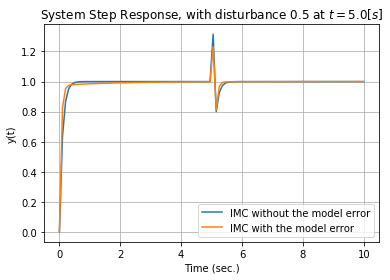

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(trange, y, label="IMC without the model error")
plt.plot(trange, y_error, label="IMC with the model error")
plt.title('System Step Response, with disturbance $0.5$ at $t=5.0[s]$')
plt.xlabel('Time (sec.)')
plt.ylabel('y(t)')
plt.grid(True)
plt.legend()
plt.show()

According to the plot, we can see the IMC make the system go along the reference value even though there is the modelling error in the model.